In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
import pyross
import pyrosstsi
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from scipy import optimize
from scipy import integrate

initiating SEAI8R


In [3]:
####################################
##                                ##
##   Population Characteristics   ##
##                                ##
####################################

#########################################
##        Population Numbers           ##
#########################################

M=16  ## number of age classes
my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
Ni = (my_data[:, 1]+ my_data[:, 2])[0:M]  #number of people in each age group
min_age = 2.5; max_age = 77.5; age = np.linspace(min_age,max_age, M)

#########################################
##          Contact Matrices           ##
#########################################

# Get individual contact matrices
CH, CW, CS, CO = pyross.contactMatrix.UK()
def contactMatrix(t):
#     if t > 3000 and t < 90:
#         return CH + 0.1*CW + 0.1*CO
#     else:
        return CH + CW + CS + CO
    
#########################################
##   Non-Epidemic Population Dynamics  ##
#########################################
    
sa        = 100*np.ones(M)  # rate of additional/removal of population by birth etc
sa[0]     = 1500            # birth
sa[12:16] = -300            # mortality


In [4]:
####################################
##                                ##
##    Disease Characteristics     ##
##                                ##
####################################

## All rates defined in units of 1/day ##

beta  = 0.0192          # infection rate constant

gE    = 1/2.72            # rate constant:  Exposed to asymptomatic
gA    = 1/3.12            # rate constant:  Activated to Infected
gIa   = 1/7               # rate constant:  Asymptomatic to Recovery
gIs   = 1/4.82            # rate constant:  Symptomatic to [Hospitalized or not]
gIh   = 1/5.66            # rate constant:  Hospitalized to [ICU or not]
gIc   = 1/4               # rate constant:  ICU to [Mortality or not]

gIsp  = 1/4.82            # Recovery rate for the non-hospitalized branch of symptomatic infected
gIhp  = 1/5.66            # Recovery rate for the non-ICU          branch of hospitalized
gIcp  = 1/4               # Recovery rate for the non-Mortem       branch of ICU

#######################
##     Splitters    ###
#######################

## Splitters are age-structured using the fitted form suggested by Jakub ##

alpha = .3*np.ones(M)#0.66*np.exp(-age/50.5)      # fraction of Activated    that follow asymptomatic branch 
hh    = .1*np.ones(M)#0.00902  *age**0.85         # fraction of Symptomatic  that follow hospitalized branch 
cc    = .1*np.ones(M)#0.0226   *age**0.713        # fraction of Hospitalized that follow ICU          branch
mm    = .5*np.ones(M)#6*10**-17*age**8.513        # fraction of ICU          that follow Mortem       branch


#######################
##    Modulators     ##
#######################

fsa   = 1.0               # the self-isolation parameter [Relative exposure of symptomatics, 1 = fully exposed]
fh    = 0.0               # relative exposure of hospitalized [1 = fully exposed]

## NOTE:  TSI code cannot yet handle age structured beta(s), which is effectively introduced by:
## (1) having age-structured alpha and fsa < 1
## (2) having age-structured hh and fh > 0
## There are ways of approximating an age-structured beta(s) using:
## (1) the 'voluntary quarantine' class or
## (2) an asymmetric contact matrix (reflecting asymmetry in infectiousness) 
## but it may not be possible to exactly reproduce SEAI8R in its current version.

In [5]:
################################################
##                                            ##
##       Probability Density Functions        ##
##                From SEAI8R                 ##
##                                            ##
################################################

#choose a representative value of the splitters to compute a representative beta(s)
aq = np.mean(alpha); hq = np.mean(hh); cq = np.mean(cc); mq = np.mean(mm)


T = 40    # longest time frame to track with TSI model
s = np.linspace(0,T,100)
 
## EXPOSED ##
PhiE = np.exp(-gE*s)     # Probability of still being exposed         after tsi s
phiE_out = gE*PhiE       # Probability density for leaving exposed    after tsi s
phiE = -phiE_out


## ACTIVATED ##
phiA_in = phiE_out       # Probability density for entering exposed   after tsi s
PhiA = np.exp(-gA*s)*np.append(0,integrate.cumtrapz(phiA_in*np.exp(gA*s),s))
                         # Probability of being in the 'activated' state at tsi s
phiA_out = gA*PhiA       # Probability density for leaving activated  after tsi s
phiA = phiA_in - phiA_out


## INFECTED - ASYMPTOMATIC ##
phiIa_in = aq*phiA_out       # Probability density for enterint Ia    after tsi s
PhiIa = np.exp(-gIa*s)*np.append(0,integrate.cumtrapz(phiIa_in*np.exp(gIa*s),s))
                             # Probability of being in Ia                at tsi s
phiIa_out = gIa*PhiIa        # Probability density for leaving Ia     after tsi s
phiIa = phiIa_in - phiIa_out


## INFECTED - SYMPTOMATIC ##
phiIs_in = (1-aq)*phiA_out       # Probability density for entering Is       after tsi s
PhiIs = np.exp(-gIs*s)*np.append(0,integrate.cumtrapz(phiIs_in*np.exp(gIs*s),s))
                                 # Probability of being in Is                   at tsi s
phiIs_out = gIs*PhiIs            # Probability density for leaving Is        after tsi s
phiIsp_in = (1-hq)*phiIs_out     # Probability density for entering Isp from Is at tsi s
PhiIsp = np.exp(-gIsp*s)*np.append(0,integrate.cumtrapz(phiIsp_in*np.exp(gIsp*s),s))
                                 # Probability of being in Isp                  at tsi s
phiIsp_out = gIsp*PhiIsp         # Probability density for leaving Isp       after tsi s
PhiIsT = PhiIs + PhiIsp          # Probability of being in Is and not Ih+    after tsi s
phiIsT = phiIs_in + phiIsp_in - phiIs_out - phiIsp_out


## INFECTED - HOSPITALIZED ##                          
phiIh_in = hq*phiIs_out          # Probability density for entering Ih     after tsi s
PhiIh = np.exp(-gIh*s)*np.append(0,integrate.cumtrapz(phiIh_in*np.exp(gIh*s),s))
                                 # Probability of  being in Ih                at tsi s
phiIh_out = gIh*PhiIh            # Probability density for leaving Ih      after tsi s
phiIhp_in = (1-cq)*phiIh_out     # Probability density for entering Ihp    after tsi s
PhiIhp = np.exp(-gIhp*s)*np.append(0,integrate.cumtrapz(phiIhp_in*np.exp(gIhp*s),s))
                                 # Probability of being in Ihp                at tsi s
phiIhp_out = gIhp*PhiIhp         # Probability density of leaving Ihp      after tsi s
PhiIhT = PhiIh + PhiIhp
phiIhT = phiIh_in + phiIhp_in - phiIh_out - phiIhp_out

## INFECTED - CRITICAL ##                          
phiIc_in = cq*phiIh_out          # Probability density for entering Ic     after tsi s
PhiIc = np.exp(-gIc*s)*np.append(0,integrate.cumtrapz(phiIc_in*np.exp(gIc*s),s))
                                 # Probability of  being in Ic                at tsi s
phiIc_out = gIc*PhiIc            # Probability density for leaving Ic      after tsi s
phiIcp_in = (1-mq)*phiIc_out     # Probability density for entering Icp    after tsi s
PhiIcp = np.exp(-gIcp*s)*np.append(0,integrate.cumtrapz(phiIcp_in*np.exp(gIcp*s),s))
                                 # Probability of being in Icp                at tsi s
phiIcp_out = gIcp*PhiIcp         # Probability density of leaving Icp      after tsi s
PhiIcT = PhiIc + PhiIcp
phiIcT = phiIc_in + phiIcp_in - phiIc_out - phiIcp_out

## INFECTED - MORTEM ##                          
phiIm_in = mq*phiIc_out          # Probability density for entering Im     after tsi s
PhiIm = np.append(0,integrate.cumtrapz(phiIm_in,s))
phiIm = phiIm_in

##  RECOVERED  ##
phiR_in = phiIa_out + phiIsp_out + phiIhp_out + phiIcp_out #prob. density for entering R at tsi s
PhiR = np.append(0,integrate.cumtrapz(phiR_in,s))          #prob of being in R           at tsi s


(0, 0.0035406722580716594)

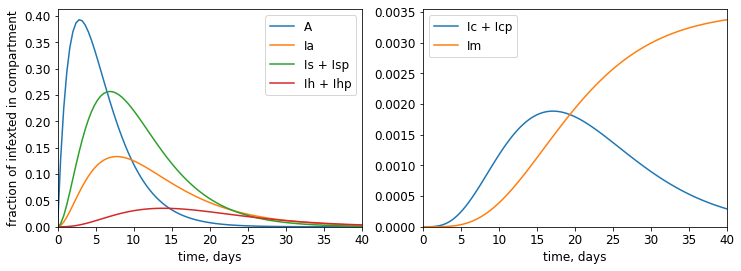

In [6]:
##  What compartment are the infecteds in?
##  Confirm that most outcomes resolve by the chosen time T

plt.figure(figsize=(12, 4)); plt.subplot(121)
plt.plot(s,PhiA,label = 'A')
plt.plot(s,PhiIa, label = 'Ia')
plt.plot(s,PhiIs,label = 'Is + Isp')
plt.plot(s,PhiIhT, label = 'Ih + Ihp')
plt.legend(); plt.xlabel('time, days'); plt.ylabel('fraction of infexted in compartment')
plt.xlim(0,np.amax(s)); plt.ylim(0)

plt.subplot(122)
plt.plot(s,PhiIcT, label = 'Ic + Icp')
plt.plot(s,PhiIm, label = 'Im')
plt.legend(); plt.xlabel('time, days'); #plt.ylabel('fraction of infexted in compartment')
plt.xlim(0,np.amax(s)); plt.ylim(0)

6.27432423201351


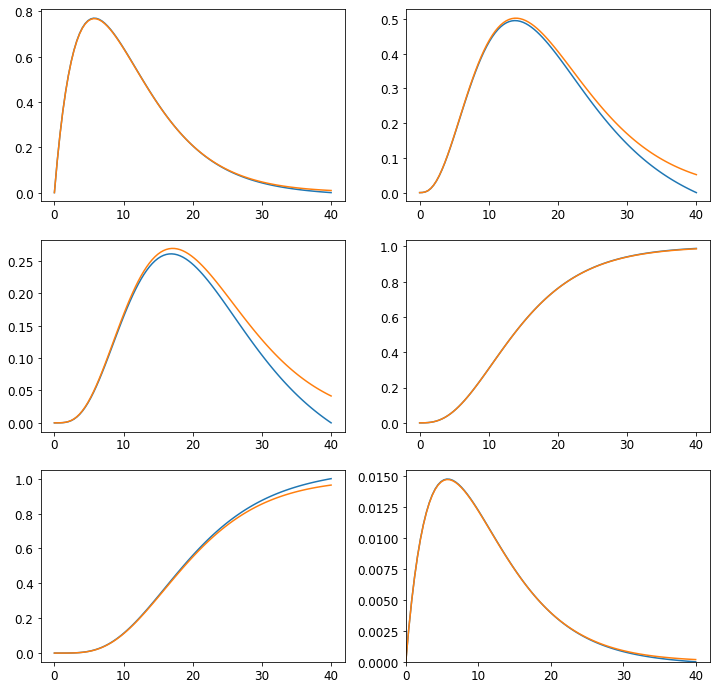

In [7]:
##############################
##  Fitting to a TSI model  ##
##############################

subclasses = ['A + Ia + Is', 'Ih', 'Ic', 'Im', 'R']
Nc = len(subclasses)

tsi_sc = s
nt = len(s)-1

#  Truncate the tails so everything resolves by time T #

# All infectious classes grouped together 
phiI = phiA + phiIa + phiIsT
phiI = phiI - 2*s/T*np.trapz(phiI,s)/T
pI = np.ones(M)            #proportion infectious is not strongly age structured in SEAI8R

# Hospitalized (not critical)
phiH = phiIhT/(1-aq)/hq
phiH = phiH - 2*s/T*np.trapz(phiH,s)/T
pH = (1-alpha)*hh          #proportion of each age class that are hospitalized

# Hospitalized - Critical
phiC = phiIcT/(1-aq)/hq/cq
phiC = phiC - 2*s/T*np.trapz(phiC,s)/T
pC = (1-alpha)*hh*cc       #proportion of each age class that fail to recover

# Mortem
dM = PhiIs[nt]*hq*cq*mq + PhiIh[nt]*cq*mq + PhiIc[nt]*mq
phiM = phiIm + 2*dM*s/T**2
phiM = phiM/(1-aq)/hq/cq/mq
pM = (1-alpha)*hh*cc*mm

# Recovered
dR = PhiIs[nt]*(1-hq + hq*((1-cq) + cq*(1-mq))) + PhiIh[nt]*(1-cq + cq*(1-mq)) + PhiIc[nt]*(1-mq)
phiR = phiR_in + 2*dR*s/T**2
pRq = aq + (1-aq)*((1-hq) + hq*((1-cq) + cq*((1-mq))))
phiR = phiR/pRq
pR = alpha + (1-alpha)*((1-hh) + hh*((1-cc) + cc*((1-mm))))

#bundle
p_alpha   = np.array([pI,   pH,   pC,   pM,   pR  ])
phi_alpha = np.array([phiI, phiH, phiC, phiM, phiR])


## Confirming (graphically) that all paths resolve at by T
## Blue lines should always resolve to 1 or 0 

plt.figure(figsize=(12, 12)); plt.subplot(321)
PhiI = np.append(0,integrate.cumtrapz(phiI,s))
plt.plot(s,PhiI)
plt.plot(s,PhiA + PhiIa + PhiIsT)                  # Plotting all Infected

plt.subplot(322)
PhiH = np.append(0,integrate.cumtrapz(phiH,s))
plt.plot(s,PhiH)
plt.plot(s,PhiIhT/(1-aq)/hq)                       # Plotting Hospitalized (not Critical)

plt.subplot(323)
PhiC = np.append(0,integrate.cumtrapz(phiC,s))
plt.plot(s,PhiC)
plt.plot(s,PhiIcT/(1-aq)/hq/cq)                    # Plotting Hospitalize (Critical)

plt.subplot(324)
Phi_R = np.append(0,integrate.cumtrapz(phiR,s))
plt.plot(s,Phi_R)
plt.plot(s,PhiR/pRq)                               # Plotting Recovered

plt.subplot(325)
PhiM = np.append(0,integrate.cumtrapz(phiM,s))
plt.plot(s,PhiM)
plt.plot(s,PhiIm/(1-aq)/hq/cq/mq)                  # Plotting Mortem

###########################
##  Calculating beta(s)  ##
###########################

tsi = s
beta_s = beta*(PhiI + fh*PhiH*hq*(1-aq))  #note:  this line needs to change if fsa < 1

plt.subplot(326)
plt.plot(tsi,beta_s)
plt.plot(s,beta*(PhiA + PhiIa + fsa*PhiIsT + fh*PhiIh))    # Plotting beta(s)
plt.xlim(0); plt.ylim(0)

###################
## Doubling time ##
###################

def Td_zero(x):
    A = np.matmul(np.diag(Ni),contactMatrix(0)); A = np.matmul(A,np.diag(1/Ni))
    A = A*np.trapz(beta_s*np.exp(-np.log(2)/x*s),s)
    max_eig_A = np.max(np.real(np.linalg.eigvals(A)))
    return (max_eig_A - 1)

sol = optimize.root_scalar(Td_zero, bracket=[2, 50])
Td = sol.root
print(Td)


(0, 0.012872018170733258)

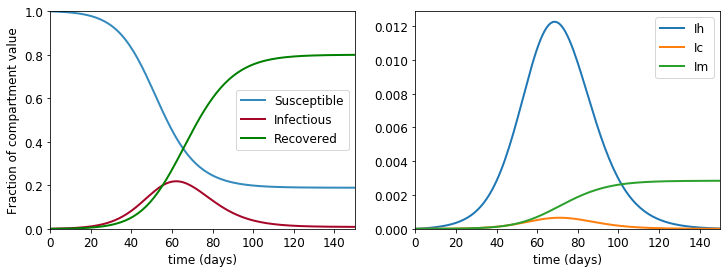

In [8]:
####################################
##                                ##
##     Running the TSI model      ##
##                                ##
####################################

Nk = 40;                   # How many stages to use -- good results with as few as Nk = 10
Tf = 150;                  # End time

tswap = np.array([30, 90, Tf])  # When to switch from Galerkin to Predictor/Corrector (if applicable)
NL = 5                     # How many Legendre polynomials to use (if applicable)

parameters = {'M':M, 'Ni':Ni, 'Nc':len(subclasses), 'Nk':Nk, 'Tf':Tf, 'Tc':(T/2), 'T':T, 'Td':Td,
              'tsi':tsi,'beta':beta_s,'tsi_sc':tsi_sc, 'phi_alpha':phi_alpha, 'p_alpha':p_alpha, 
              'contactMatrix':contactMatrix, 'NL':NL, 'tswap':tswap}

model = pyrosstsi.deterministic.Simulator(parameters)#,'Hybrid')
IC    = model.get_IC()
data  = model.simulate(IC)

#############

#unpack and rescale simulation output
t = data['t']; S_t = data['S_t']; I_t = data['I_t']; Ic_t = data['Ic_t'] 

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(t,np.sum(S_t,0), color="#348ABD", lw=2, label = 'Susceptible')           #all susceptible
plt.plot(t,np.sum(Ic_t[0,:,:],0), color="#A60628", lw=2, label = 'Infectious')    #all Infectious (Ia + Is)
plt.plot(t,np.sum(Ic_t[4,:,:],0), color='green', lw=2, label = 'Recovered')       #all Recovered
plt.xlabel('time (days)');       plt.xlim(0,Tf);  plt.ylim(0,1)
plt.ylabel('Fraction of compartment value');   plt.legend()

plt.subplot(122) 
for i in (1 + np.arange(len(subclasses)-2)):
    plt.plot(t,np.sum(Ic_t[i,:,:],0), lw=2, label = subclasses[i])
plt.legend(); plt.xlabel('time (days)'); plt.xlabel('time (days)'); plt.xlim(0,Tf);  plt.ylim(0)  

(0, 0.013737383928843215)

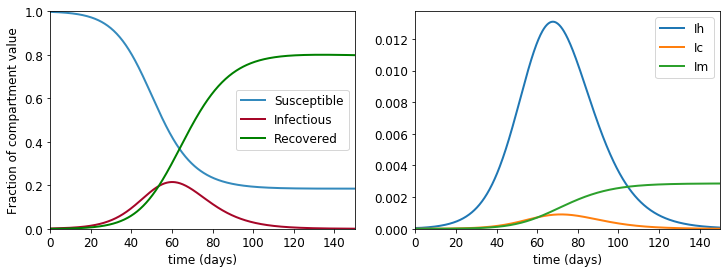

In [9]:
####################################
##                                ##
##    Running SEAI8R Directly     ##
##                                ##
####################################
Nf = 600

# initial conditions    
Is_0 = np.zeros((M));  #Is_0[6:13]=8;  Is_0[2:6]=4; Is_0[13:16]=4


Ia_0 = 1000*np.ones((M));  
R_0  = np.zeros((M))
E_0  = np.zeros((M))
A_0  = np.zeros((M))
Ih_0  = np.zeros((M))
Ihp_0  = np.zeros((M))
Ic_0  = np.zeros((M))
Icp_0  = np.zeros((M))
Isp_0  = np.zeros((M))
Im_0  = np.zeros((M))

for i in range(M):
    s0 = np.linspace(0,T,Nk)
    I0 = np.interp(s,s0,IC[1][:,i])*np.sum(Ni)/M
    E_0[i]  = np.trapz(PhiE* I0, s)
    A_0[i]  = np.trapz(PhiA* I0, s)
    Ia_0[i] = np.trapz(PhiIa*I0, s)*alpha[i]/aq
    Is_0[i] = np.trapz(PhiIs*I0, s)*(1-alpha[i])/(1-aq)
    Ih_0[i] = np.trapz(PhiH*I0, s)*(1-alpha[i])*hh[i]
    Ic_0[i] = np.trapz(PhiC*I0, s)*(1-alpha[i])*hh[i]*cc[i]
    Im_0[i] = np.trapz(PhiM*I0, s)*(1-alpha[i])*hh[i]*cc[i]*mm[i]
    
    Isp_0[i] = np.trapz(PhiIsp*I0, s)*(1-alpha[i])*(1-hh[i])/((1-aq)*(1-hq))
    Ihp_0[i] = np.trapz(PhiIhp*I0, s)*(1-alpha[i])*(1-hh[i])*(1-cc[i])/((1-hq)*(1-cq))
    Icp_0[i] = np.trapz(PhiIcp*I0, s)*(1-alpha[i])*(1-hh[i])*(1-cc[i])*(1-mm[i])/((1-aq)*(1-hq)*(1-cq)*(1-mq))

S_0  = Ni - (E_0 + A_0 + Ia_0 + Is_0 + Isp_0+ Icp_0+ Ihp_0 + Ih_0 + Ic_0  + R_0)
    
Tf = 150

# instantiate model
parameters2 = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 'gIsp':gIsp, 'gIcp':gIcp, 'gIhp':gIhp,
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.deterministic.SEAI8R(parameters2, M, Ni)
data  = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Isp_0, Ih_0, 
                       Ih_0, Ic_0, Icp_0, Im_0, contactMatrix, Tf, Nf)

## Plot Results ##

Infectious = (model.Is(data) + model.Isp(data) + model.A(data) + model.Ia(data))/np.sum(Ni)
S = model.S(data)/np.sum(Ni);
R = model.R(data)/np.sum(Ni);
Ih = (model.Ih(data) + model.Ihp(data))/np.sum(Ni)
Ic = (model.Ic(data) + model.Icp(data))/np.sum(Ni)
Im = model.Im(data)/np.sum(Ni)

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(data['t'], np.sum(S,1),              color = "#348ABD", label = 'Susceptible',lw = 2)
plt.plot(data['t'], Infectious.sum(axis = 1), color = "#A60628", label = 'Infectious' ,lw = 2)
plt.plot(data['t'], np.sum(R,1),              color = 'green',   label = 'Recovered'  ,lw = 2)
plt.xlabel('time (days)');       plt.xlim(0,Tf);  plt.ylim(0,1)
plt.ylabel('Fraction of compartment value');   plt.legend()


plt.subplot(122)
plt.plot(data['t'],np.sum(Ih,1), lw = 2, label = 'Ih')
plt.plot(data['t'],np.sum(Ic,1), lw = 2, label = 'Ic')
plt.plot(data['t'],np.sum(Im,1), lw = 2, label = 'Im')
plt.legend(); plt.xlabel('time (days)'); plt.xlabel('time (days)'); plt.xlim(0,Tf);  plt.ylim(0)  


In [10]:
A = np.zeros((M*5,M*5))
Cij = np.matmul(np.diag(Ni),contactMatrix(0)); Cij = beta*np.matmul(Cij,np.diag(1/Ni))

# E equations
for i in range(M):
    A[i,i] = -gE
    A[i,1*M + np.arange(M)] = Cij[i,:]
    A[i,2*M + np.arange(M)] = Cij[i,:]
    A[i,3*M + np.arange(M)] = Cij[i,:]*fsa
    A[i,4*M + np.arange(M)] = Cij[i,:]*fsa
    
# E equations
for i in range(M):
    A[1*M + i,1*M + i] = -gA
    A[1*M + i,0*M + i] = +gE
    
# Ia Equations
for i in range(M):
    A[2*M + i,2*M + i] = -gIs
    A[2*M + i,1*M + i] = +gA*alpha[i]

# Is Equations
for i in range(M):
    A[3*M + i,3*M + i] = -gIs
    A[3*M + i,1*M + i] = +gA*(1-alpha[i])
    
# Isp Equations
for i in range(M):
    A[4*M + i,4*M + i] = -gIsp
    A[4*M + i,3*M + i] = +gIs*(1-hh[i])
    
lam = np.amax(np.real(np.linalg.eigvals(A)))

Td = np.log(2)/lam

print(Td)
    

6.544869860417442


In [11]:
A = np.zeros((M*5,M*5))
Cij = np.matmul(np.diag(Ni),contactMatrix(0)); Cij = beta*np.matmul(Cij,np.diag(1/Ni))

# E equations
for i in range(M):
    A[i,i] = -gE
    A[i,1*M + np.arange(M)] = Cij[i,:]
    A[i,2*M + np.arange(M)] = Cij[i,:]
    A[i,3*M + np.arange(M)] = Cij[i,:]*fsa
    A[i,4*M + np.arange(M)] = Cij[i,:]*fsa
    
# E equations
for i in range(M):
    A[1*M + i,1*M + i] = -gA
    A[1*M + i,0*M + i] = +gE
    
# Ia Equations
for i in range(M):
    A[2*M + i,2*M + i] = -gIs
    A[2*M + i,1*M + i] = +gA*alpha[i]

# Is Equations
for i in range(M):
    A[3*M + i,3*M + i] = -gIs
    A[3*M + i,1*M + i] = +gA*(1-alpha[i])
    
# Isp Equations
for i in range(M):
    A[4*M + i,4*M + i] = -gIsp
    A[4*M + i,3*M + i] = +gIs*(1-hh[i])
    
lam = np.amax(np.real(np.linalg.eigvals(A)))

Td = np.log(2)/lam

print(Td)
    

6.544869860417442
